# COVID-19-Affected Lung CT Generative Network Demo

# Initialize

### Import Dependencies

In [1]:
import tensorflow as tf
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import zipfile
import cv2
from matplotlib import image
import sys

### Load from Google Drive or Local

In [2]:
# Set to True if you want to load data and save models to Google Drive
# Set to False if you want to load and save locally.
load_data_from_Google_Drive = False

# Names of models to load
generator = "COVID_CT_GAN_Generator.h5"
discriminator = "COVID_CT_GAN_Discriminator.h5"
gan = "COVID_CT_GAN_GAN.h5"

# Name of dataset zip file without .zip extension
Dataset = "CT_COVID"

## Load Model and Data
If loading from Google Drive, assumes models specified by `generator`, `discriminator`, `gan`, as well as `CT_COVID.zip` are in `My Drive/COVID-19-Affected Lung CT Generative Network`.  
If loading locally, assumes they are in the same directory as this file.

### Mount Google Drive
To get access to dataset and for model saving  
Runs IF load_data_from_Google_Drive is true

In [ ]:
if load_data_from_Google_Drive:
  from google.colab import drive
  drive.mount('/content/gdrive')

### Load Model

In [ ]:
if load_data_from_Google_Drive:
  filepath = "/content/gdrive/My Drive/COVID-19-Affected Lung CT Generative Network"
  destination = "/gdrive/Data"
else:
  filepath = os.getcwd()
  destination = os.getcwd()+"/Data"

generator = tf.keras.models.load_model(filepath+"/COVID_CT_GAN_Generator.h5")
discriminator = tf.keras.models.load_model(filepath+"/COVID_CT_GAN_Discriminator.h5")
gan = tf.keras.models.load_model(filepath+"/COVID_CT_GAN_GAN.h5")


In [ ]:
sys.path.append(filepath)

import imp
import interpolate
imp.reload(interpolate)
from interpolate import model_progression

### Load Original Data

In [ ]:
# Will unzip the files so that you can see them..
with zipfile.ZipFile(filepath+"/"+Dataset+".zip","r") as z:
    z.extractall(destination)

from subprocess import check_output
#print(check_output(["ls", "/gdrive/Data/CT_COVID"]).decode("utf8"))

# link used: https://www.pyimagesearch.com/2019/01/14/machine-learning-in-python/
os.chdir(destination + "/" + Dataset)

path = "*.*"
data = []
for file in glob.glob(path):
  if(file.find("image_at_epoch") == -1):
    img_data = image.imread(file, 0)
    data.append(img_data)  
data = np.array(data)

from skimage.color import rgb2gray
WIDTH=128
HEIGHT=128
standardized_data = []
for img in data:
  img = rgb2gray(img)
  img2 = np.flip(img, axis=1) ## ADD FLIPPED IMAGE FOR LARGER DATA SET
  standardized_data.append(cv2.resize(img, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
  standardized_data.append(cv2.resize(img2, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC).astype('float32'))
train_images = np.array(standardized_data)
train_images = train_images.reshape(train_images.shape[0], 128,128,1).astype('float32')
print(train_images.shape)

train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]
#os.system("rm -r \""+destination+"\"")

# Demo

## Generate Random Image from Noise

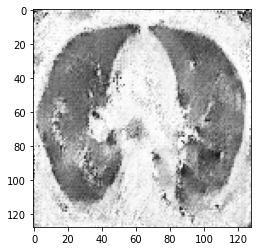

In [ ]:
noise = tf.random.normal([1, 100])
generated_image0 = generator.predict(noise)

plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
plt.show()


## Generate Various Images

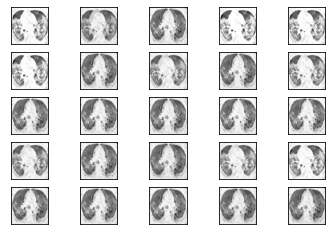

In [6]:
f = plt.figure()
noise_dim = 100
for i in range(1,26):
  f.add_subplot(5,5, i)
  noise = np.random.randn(noise_dim)
  noise = noise.reshape(1, noise_dim)
  generated_image0 = generator.predict(noise)
  plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
  plt.xticks([])
  plt.yticks([])
plt.show()

## Generate Image From Inputted Noise Vector

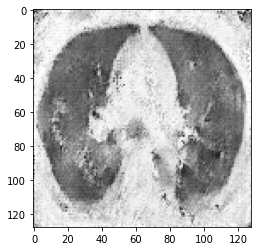

In [9]:
noise =[[0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,
         0,0,0,0,0,0,0,0,0,0,]]
generated_image0 = generator.predict(noise)

plt.imshow(generated_image0[0, :, :, 0], cmap='gray')
plt.show()


## Interpolation Example

Code adapted from: https://machinelearningmastery.com/how-to-interpolate-and-perform-vector-arithmetic-with-faces-using-a-generative-adversarial-network/

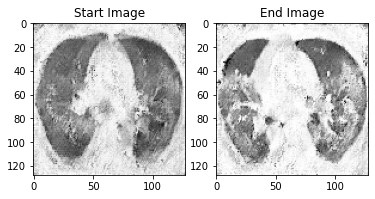

In [ ]:
start_noise = tf.random.normal([1, 100])
generated_image1 = generator.predict(start_noise)

end_noise = tf.random.normal([1, 100])
generated_image2 = generator.predict(end_noise)

f = plt.figure()
f.add_subplot(1, 2, 1)
plt.title('Start Image')
plt.imshow(generated_image1[0,:,:,0], cmap='gray')
f.add_subplot(1, 2, 2)
plt.title('End Image')
plt.imshow(generated_image2[0,:,:,0], cmap='gray')
plt.show()

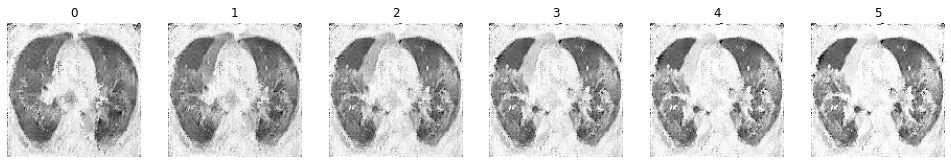

In [ ]:
model_progression(generator, start=start_noise, end=end_noise, steps=6, display=6)